# Quantum SVM (QSVM) on the Wine Dataset

This notebook is adapted from: https://github.com/PacktPublishing/A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization/blob/main/Chapter09/Chapter_09_code.ipynb

This notebook reproduces the QSVM pipeline:
1) Load Wine → (optional) binary subset → train/test split → MaxAbs scaling (clip to valid range).  
2) Amplitude-encoding overlap kernel → SVM → accuracy → confusion matrix.  
3) PCA dimensionality reduction (qubit economy).  
4) Angle-encoding overlap kernel → SVM → accuracy → confusion matrix.  
5) Entangling ZZ feature map → SVM → accuracy → confusion matrix.



## Background: kernels, quantum overlap, and callable kernels

A kernel SVM needs pairwise similarities $k(x,z)=\langle \phi(x),\phi(z)\rangle$.  
Quantum overlap (inverse-circuit) estimates fidelity $|\langle \phi(z)|\phi(x)\rangle|^2$ by embedding $x$, then applying the adjoint embedding of $z$, and reading the $|0\ldots 0\rangle$ probability.  
We expose this to scikit-learn via a callable kernel: `qkernel(A,B)` returns the matrix with entries $k(A_i,B_j)$.


In [ ]:
pip install pennylane

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

import pennylane as qml
from itertools import combinations

# Reproducibility
seed = 1234
np.random.seed(seed)


## Make a binary dataset

- The 59 first elements are from category 0.
- The 71 subsequent elements are from category 1.
- Slice `x = x[:59+71]`, `y = y[:59+71]` to drop the third category entirely.


In [ ]:
# Load Wine (features x, labels y)
x, y = load_wine(return_X_y=True)

# Keep exactly the first 59 (label 0) and next 71 (label 1)
x = x[:59+71]
y = y[:59+71]

# Train/test split (90% train)
x_tr, x_test, y_tr, y_test = train_test_split(x, y, train_size=0.9, random_state=seed)

print("Shapes:", x.shape, y.shape, "| unique labels:", np.unique(y))
print("Train:", x_tr.shape, "Test:", x_test.shape)



Shapes: (130, 13) (130,) | unique labels: [0 1]
Train: (117, 13) Test: (13, 13)


## Scale features for quantum embeddings (MaxAbs) and clip to [0, 1]

- MaxAbsScaler rescales each feature by the training-set max absolute value.
- With nonnegative features this maps into [0, 1].
- Clip test features to [0, 1] to match amplitude/angle embedding assumptions.


In [ ]:
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)
x_test = scaler.transform(x_test)
x_test = np.clip(x_test, 0.0, 1.0)

x_tr.shape, x_test.shape


((117, 13), (13, 13))

## Amplitude-encoding overlap (fidelity) kernel

- Use 4 qubits so `2^4 = 16 >= 13` features.
- Embed `a` with `AmplitudeEmbedding`, then apply the adjoint embedding of `b`.
- Probability of `|0…0⟩` equals the fidelity `|⟨φ(b)|φ(a)⟩|^2`, our kernel value.
- Expose as a scikit-learn callable kernel `qkernel_amp(A, B)`.


In [ ]:
nqubits_amp = 4  # 2^4 = 16 ≥ 13
dev_amp = qml.device("lightning.qubit", wires=nqubits_amp)

@qml.qnode(dev_amp)
def overlap_amp(a, b):
    qml.AmplitudeEmbedding(a, wires=range(nqubits_amp), pad_with=0.0, normalize=True)
    qml.adjoint(qml.AmplitudeEmbedding)(b, wires=range(nqubits_amp), pad_with=0.0, normalize=True)
    return qml.probs(wires=range(nqubits_amp))  # probs[0] is fidelity

def qkernel_amp(A, B):
    return np.array([[overlap_amp(a, b)[0] for b in B] for a in A], dtype=float)


## QSVM with amplitude kernel → accuracy
Train `SVC(kernel=qkernel_amp)` on the training set and evaluate on the test set.


In [ ]:
svm_amp = SVC(kernel=qkernel_amp, random_state=seed)
svm_amp.fit(x_tr, y_tr)

y_pred_amp = svm_amp.predict(x_test)
acc_amp = accuracy_score(y_test, y_pred_amp)
print(f"Amplitude-encoding QSVM accuracy: {acc_amp:.4f}")


Amplitude-encoding QSVM accuracy: 0.9231


<Figure size 640x480 with 0 Axes>

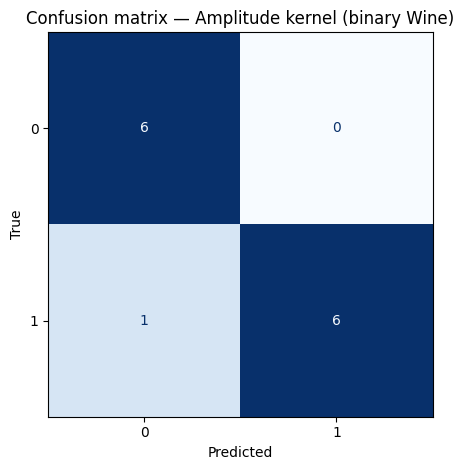

In [ ]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_amp, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure()
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Confusion matrix — Amplitude kernel (binary Wine)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## PCA (dimensionality reduction) for angle/ZZ encodings

- Reduce to `n_components` principal components (fit on train, transform both).
- This lets us use `n_components` qubits while preserving most variance.


In [ ]:
n_components = 8  # adjust as desired
pca = PCA(n_components=n_components, random_state=seed)
xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)

xs_tr.shape, xs_test.shape


((117, 8), (13, 8))

## Angle-encoding overlap (fidelity) kernel

- Each PCA component controls a rotation on a distinct qubit.
- Embed `a` with `AngleEmbedding`, apply the adjoint of the embedding for `b`.
- Read probability of `|0…0⟩` as the kernel value.


In [ ]:
nqubits_ang = n_components
dev_ang = qml.device("lightning.qubit", wires=nqubits_ang)

@qml.qnode(dev_ang)
def overlap_ang(a, b):
    qml.AngleEmbedding(a, wires=range(nqubits_ang))
    qml.adjoint(qml.AngleEmbedding)(b, wires=range(nqubits_ang))
    return qml.probs(wires=range(nqubits_ang))

def qkernel_ang(A, B):
    return np.array([[overlap_ang(a, b)[0] for b in B] for a in A], dtype=float)

svm_ang = SVC(kernel=qkernel_ang, random_state=seed)
svm_ang.fit(xs_tr, y_tr)

y_pred_ang = svm_ang.predict(xs_test)
acc_ang = accuracy_score(y_test, y_pred_ang)
print(f"Angle-encoding QSVM accuracy: {acc_ang:.4f}")


Angle-encoding QSVM accuracy: 1.0000


<Figure size 640x480 with 0 Axes>

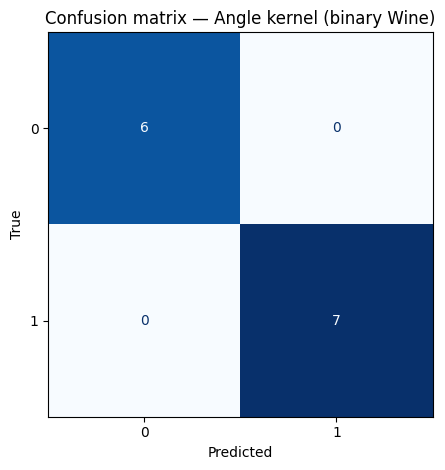

In [ ]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_ang, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure()
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Confusion matrix — Angle kernel (binary Wine)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## ZZ feature map (entangling) overlap kernel

- Simple entangling map: Hadamards + RZ(data) + pairwise CZ entanglers.
- Use inverse-circuit overlap to obtain fidelity as the kernel value.
- Train SVM and evaluate accuracy.


In [ ]:
def ZZFeatureMap(nqubits, data):
    nload = min(len(data), nqubits)
    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires=i)
    for (q0, q1) in combinations(range(nload), 2):
        qml.CZ(wires=[q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) * (np.pi - data[q1]), wires=q1)
        qml.CZ(wires=[q0, q1])

nqubits_zz = min(4, xs_tr.shape[1])
dev_zz = qml.device("lightning.qubit", wires=nqubits_zz)

@qml.qnode(dev_zz)
def overlap_zz(a, b):
    ZZFeatureMap(nqubits_zz, a)
    qml.adjoint(ZZFeatureMap)(nqubits_zz, b)
    return qml.probs(wires=range(nqubits_zz))

def qkernel_zz(A, B):
    return np.array([[overlap_zz(a, b)[0] for b in B] for a in A], dtype=float)

svm_zz = SVC(kernel=qkernel_zz, random_state=seed)
svm_zz.fit(xs_tr, y_tr)

y_pred_zz = svm_zz.predict(xs_test)
acc_zz = accuracy_score(y_test, y_pred_zz)
print(f"ZZ-feature QSVM accuracy: {acc_zz:.4f}")


ZZ-feature QSVM accuracy: 0.8462


<Figure size 640x480 with 0 Axes>

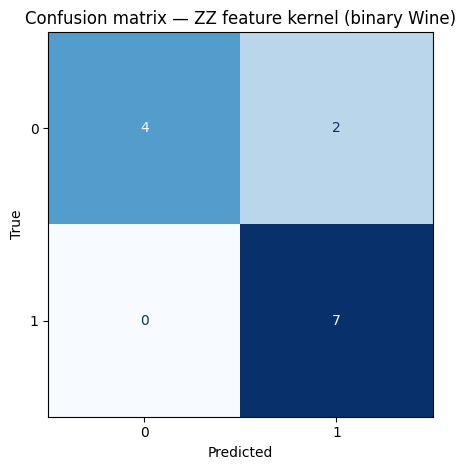

In [ ]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_zz, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure()
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Confusion matrix — ZZ feature kernel (binary Wine)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
